In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.gridspec import GridSpec
import seaborn as sns 
%matplotlib inline 
from matplotlib import rc
rc('font', family = 'AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
from plotly.subplots import make_subplots
import plotly.graph_objects as go
plt.style.use(['ggplot'])

# 주별표시 
from math import ceil
from datetime import datetime, timezone, timedelta
pd.options.display.max_rows=1000

#추천시스템
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.naive_bayes import MultinomialNB
from sklearn.manifold import TSNE


from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday
import platform
import missingno as msno
from datetime import datetime, timezone, timedelta
import pytz
from tqdm.notebook import tqdm as tqdm

import warnings
warnings.filterwarnings(action='ignore')

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

pd.options.display.float_format = '{:.0f}'.format
pd.options.display.max_rows=1000

### 프로젝트 불러오기

In [2]:
df = pd.read_csv('과제수정DB.csv')

### 기본 구조 확인

In [3]:
print(f'기본 Dataset 구조 : {df.shape}')
print('='*80)
print(df.info())

기본 Dataset 구조 : (1471, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1471 entries, 0 to 1470
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   brandnm     1469 non-null   object
 1   goodsnm     1471 non-null   object
 2   USER        1471 non-null   object
 3   reg_date    1471 non-null   object
 4   order_date  1471 non-null   object
 5   p_type      1471 non-null   object
 6   sub_type    1471 non-null   object
 7   app_yn      1295 non-null   object
dtypes: object(8)
memory usage: 92.1+ KB
None


### 각 column별 의미
* brandnm: 브랜드명
* goodsnm: 아이템 명
* USER: 개별 유저 식별 값
* reg_date: 개별 유저 가입일
* order_date: 아이템 주문일
* P_type: 주문 상품 종류 (7일권 / 4일권)
* sub_type: 주문 상품 카테고리 (BA-가방/ O-아우터/ D-드레스/ T-상의/ B-하의/ TB-투피스)
* app_yn: 어플리케이션 사용 여부(Y-사용 / 공백-미사용)
####  - 의류,가방은 1회에 4일 또는 7일 대여

### 결측치 처리
* brandnm: 클로젯셰어 검색결과로 도출, 2개의 결측치는 예측 불가하여 입력 X
* reg_date: USER의 번호가 순차적인것을 짐작하여 입력

### app_yn에 'N' 넣어주기

In [4]:
df.app_yn.fillna('N', inplace=True)

## brandnm의 결측치 2가지 drop

<AxesSubplot:>

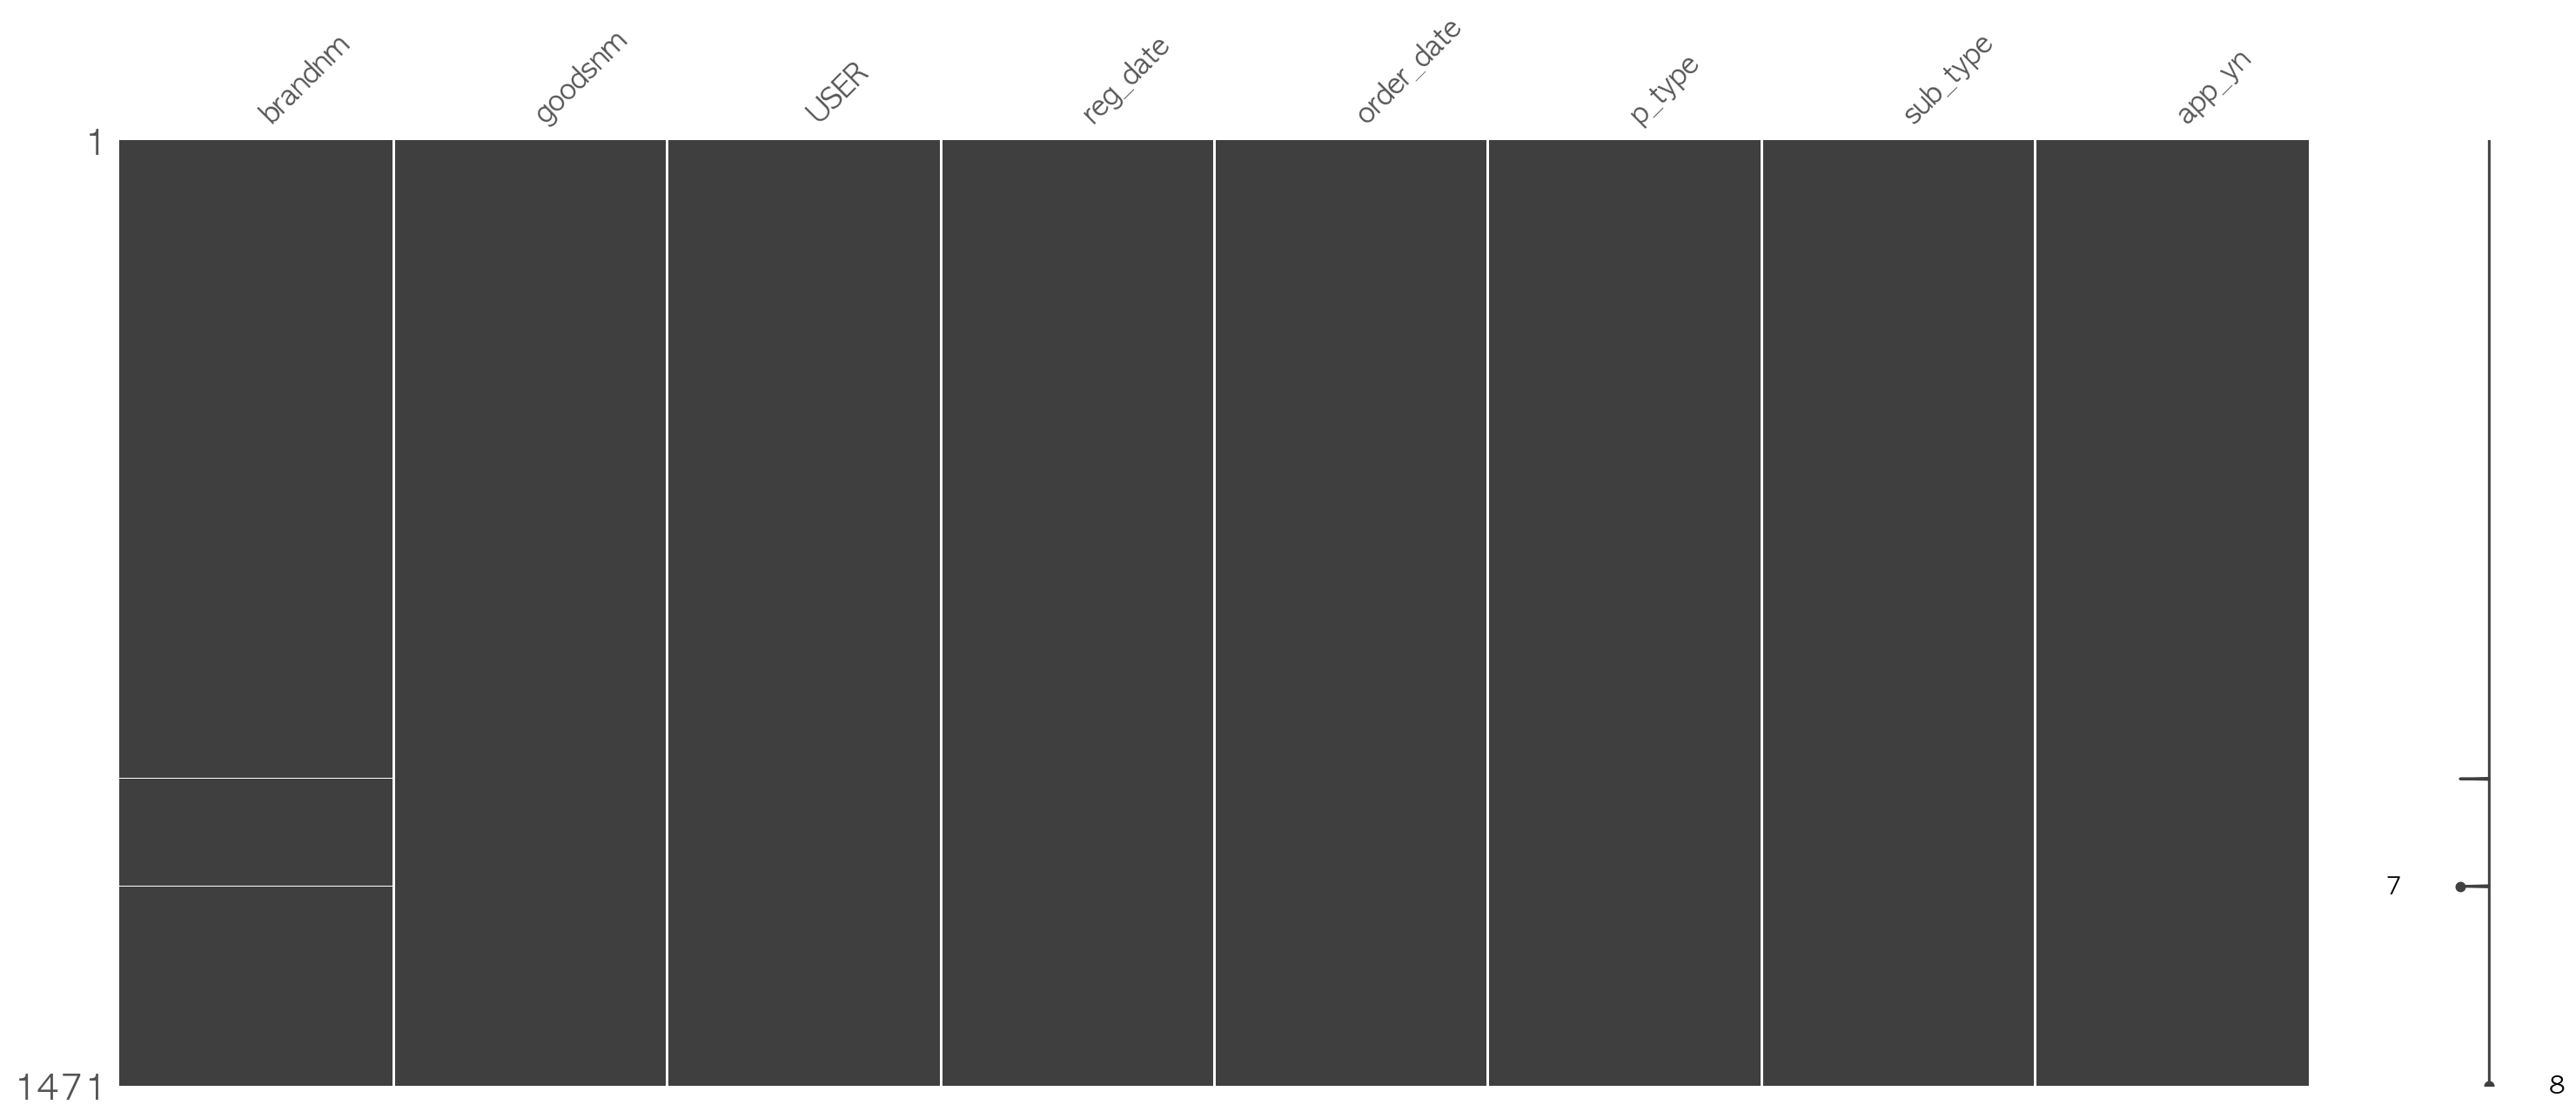

In [5]:
msno.matrix(df)

### EDA를 통해 데이터 살펴보기
* 1. 구매 소요 시간 분석
*  1-1. 가입일, 구매일의 경과일을 살펴보기
* 2. 구매 상품 트렌드 분석
*  2-1. 유저당 주문 수량 분석
*  2-2. 주문 아이템 분석

### 구매 소요 시간 주 단위로 살펴보기

In [6]:
# 당월 n주차 구해보기
# 가입날짜부터 주차별로 나열하기
df['reg_date'] = pd.to_datetime(df['reg_date'])
df['order_date'] = pd.to_datetime(df['order_date'])
df['reg_date_ym']=df['reg_date'].dt.strftime('%y-%m')
df['reg_date_w']='NaN'

#당월 n주차 구하는 함수 
def week_of_month(dt):

    first_day = dt.replace(day=1)

    dom = dt.day
    adjusted_dom = dom + first_day.weekday()

    return int(ceil(adjusted_dom/7.0))

#당월 n주차 구하기
for idx, (y, m, n) in enumerate(zip(df.reg_date.dt.year, df.reg_date.dt.month, df.reg_date.dt.day)) :
    temp_week=week_of_month(datetime(y,m,n))
    df['reg_date_w'][idx]= temp_week

df['reg_date_ymw']=df.reg_date_ym+'-'+df.reg_date_w.astype(str)

In [7]:
# 주문 날짜도 주차별로 보기
df['order_date_ym']=df['order_date'].dt.strftime('%y-%m')
df['order_date_w']=0
for idx, (y, m, n) in enumerate(zip(df.order_date.dt.year, df.order_date.dt.month, df.order_date.dt.day)) :
    temp_week=week_of_month(datetime(y,m,n))
    df['order_date_w'][idx]= temp_week

df['order_date_ymw']=df.order_date_ym+'-'+df.order_date_w.astype(str)

In [8]:
# 필요없는 column 드랍
drop_cols=['reg_date_ym','reg_date_w','order_date_w','order_date_ym','order_date_w','reg_date_w']

data = df.drop(drop_cols, 1)

In [9]:
# 주차별 주문 수 확인

order = data.groupby('order_date_ymw').count()['USER'].reset_index()

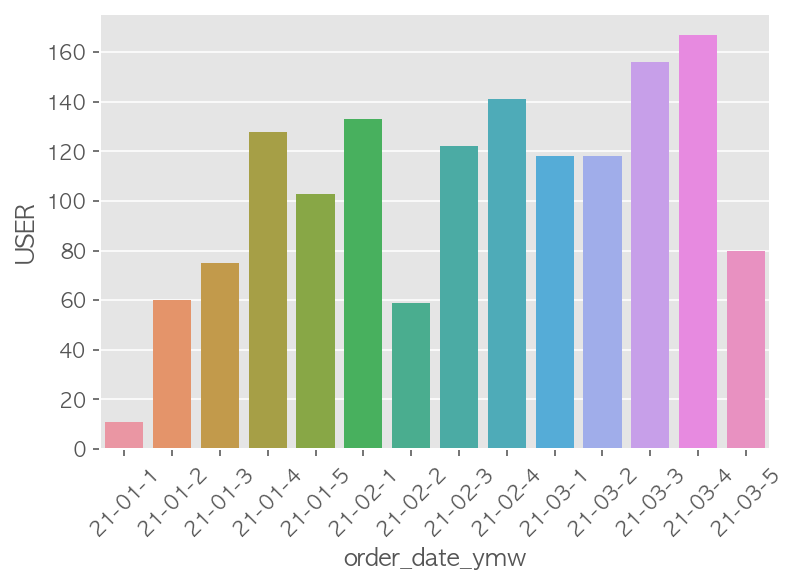

In [10]:
sns.barplot(data=order, x='order_date_ymw', y='USER')
plt.xticks(rotation = 45)
plt.show()

### 월별로도 확인

In [11]:
month_list = [
    (data['order_date'] <='2021-01-31'),
    (data['order_date'] <='2021-02-28') & (data['order_date'] >'2021-01-31'),
    (data['order_date'] <='2021-03-31') & (data['order_date'] >'2021-02-28')]

indi_list = ['1월구매자', '2월구매자', '3월구매자']

data['월별구매자'] = np.select(month_list, indi_list)

In [12]:
buyer_type = data.groupby(['sub_type', '월별구매자']).count()['USER'].sort_values(ascending=False).reset_index()
buyer_type

,sub_type,월별구매자,USER
0,BA,3월구매자,310
1,BA,2월구매자,234
2,BA,1월구매자,148
3,D,3월구매자,128
4,O,2월구매자,97
5,O,3월구매자,87
6,O,1월구매자,83
7,D,2월구매자,69
8,T,3월구매자,65
9,D,1월구매자,64


### 월별로 구매가 늘어나며 가방과 드레스의 렌탈 상승이 보임

<AxesSubplot:xlabel='sub_type', ylabel='USER'>

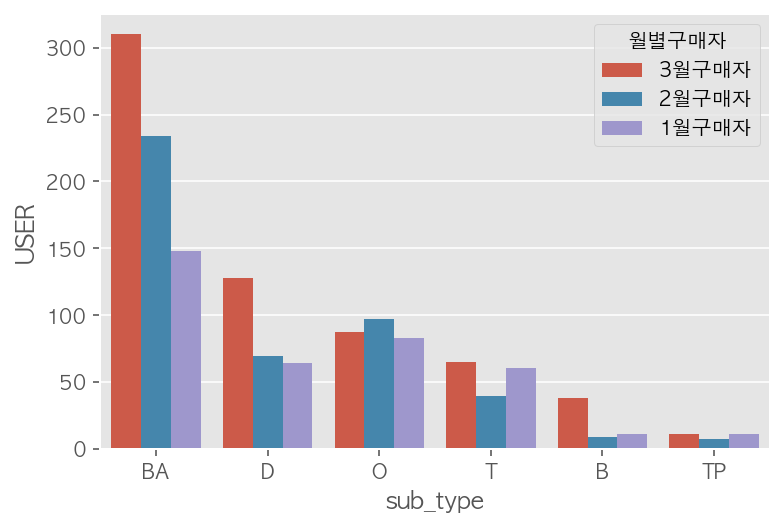

In [13]:
sns.barplot(data = buyer_type, x='sub_type', y='USER', hue='월별구매자')

### 브랜드 인기 순위 top 20 확인

In [14]:
top_20 = data.groupby(['brandnm', 'sub_type']).count()['USER'].sort_values(ascending=False)[:24].reset_index()
top_20

,brandnm,sub_type,USER
0,Gucci,BA,204
1,Saint Laurent,BA,84
2,Louis Vuitton,BA,77
3,Chanel,BA,75
4,Prada,BA,38
5,Yves Saint Laurent,BA,34
6,Burberry,O,30
7,Fendi,BA,23
8,Celine,BA,20
9,Max Mara,O,18


<AxesSubplot:xlabel='brandnm', ylabel='USER'>

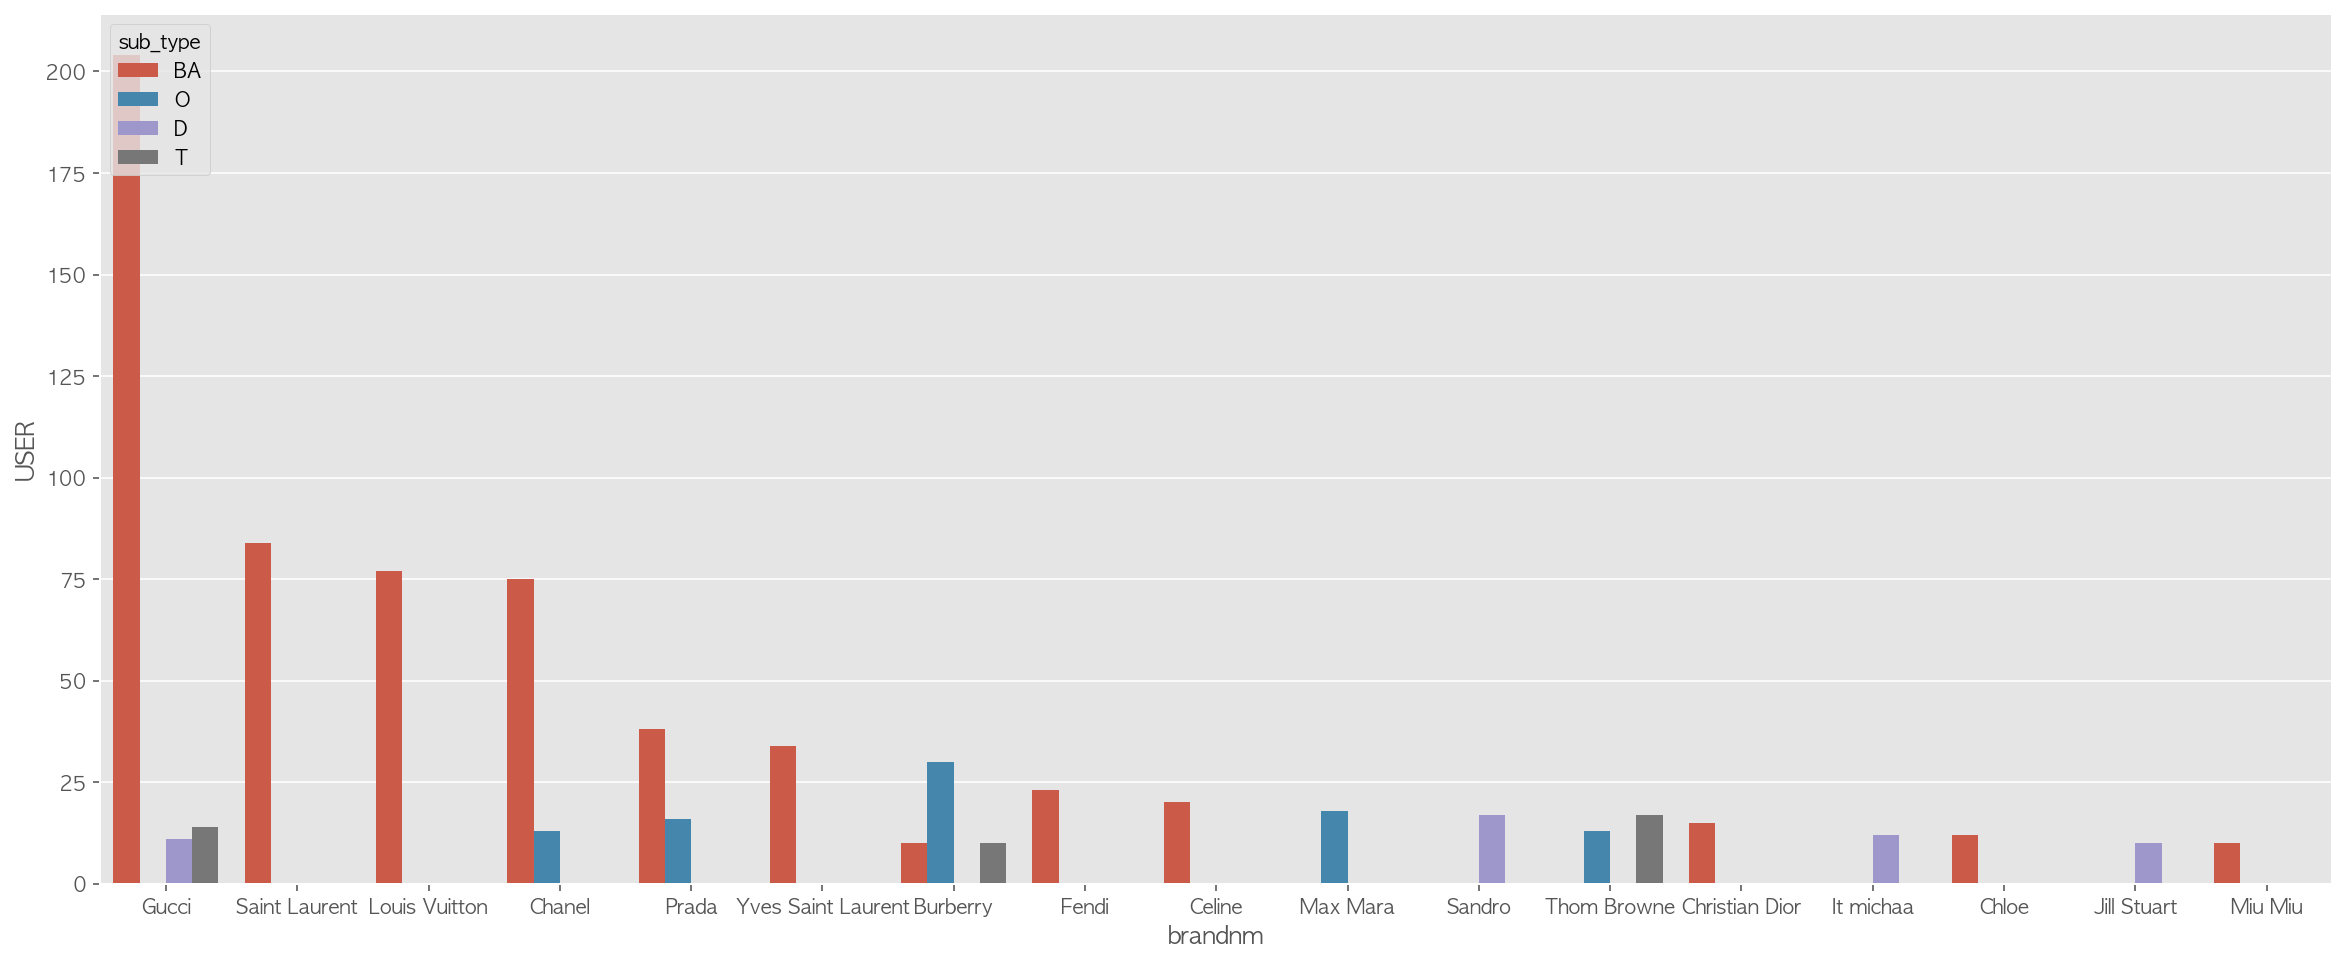

In [15]:
plt.figure(figsize=(20,8))
sns.barplot(data=top_20, x='brandnm', y='USER', hue='sub_type')


### 어떤 색상이 많이 나왔는지 확인

In [16]:
data['component'] = data['goodsnm'].str.split()

In [17]:
data['color'] = 0

def color_ext(color):
    for i in range(len(data)):
        if (color in data['component'][i]): 
            data['color'].iloc[i]=color

In [18]:
color_list = ['beige','black','blue','pink','navy','ivory',
             'white','brown','cream','purple','deeppink',
             'nude','burgundy','grey','red',
            'skyblue', 'gold','mint','green','yellow',
             'collar','charcoal',' khaki','orange','lavender','mustard',
             'wine','salmon','multi','rainbow','bluegreen','black&beige',
             'olive']

for i in color_list:
    color_ext(i)

In [19]:
# 중복 색 처리
for i in range(len(data)):
    if ('gray' in data['component'][i]):
       data['color'].iloc[i] = 'grey'
    if ('gray_1' in data['component'][i]):
       data['color'].iloc[i] = 'grey'
    if ('black1' in data['component'][i]):
       data['color'].iloc[i] = 'black'
    if ('black_1' in data['component'][i]):
       data['color'].iloc[i] = 'black'
    if ('Black' in data['component'][i]):
       data['color'].iloc[i] = 'black'

In [20]:
color = data.groupby('color').count()['USER'].sort_values(ascending=False)[:20].reset_index()

<AxesSubplot:xlabel='color', ylabel='USER'>

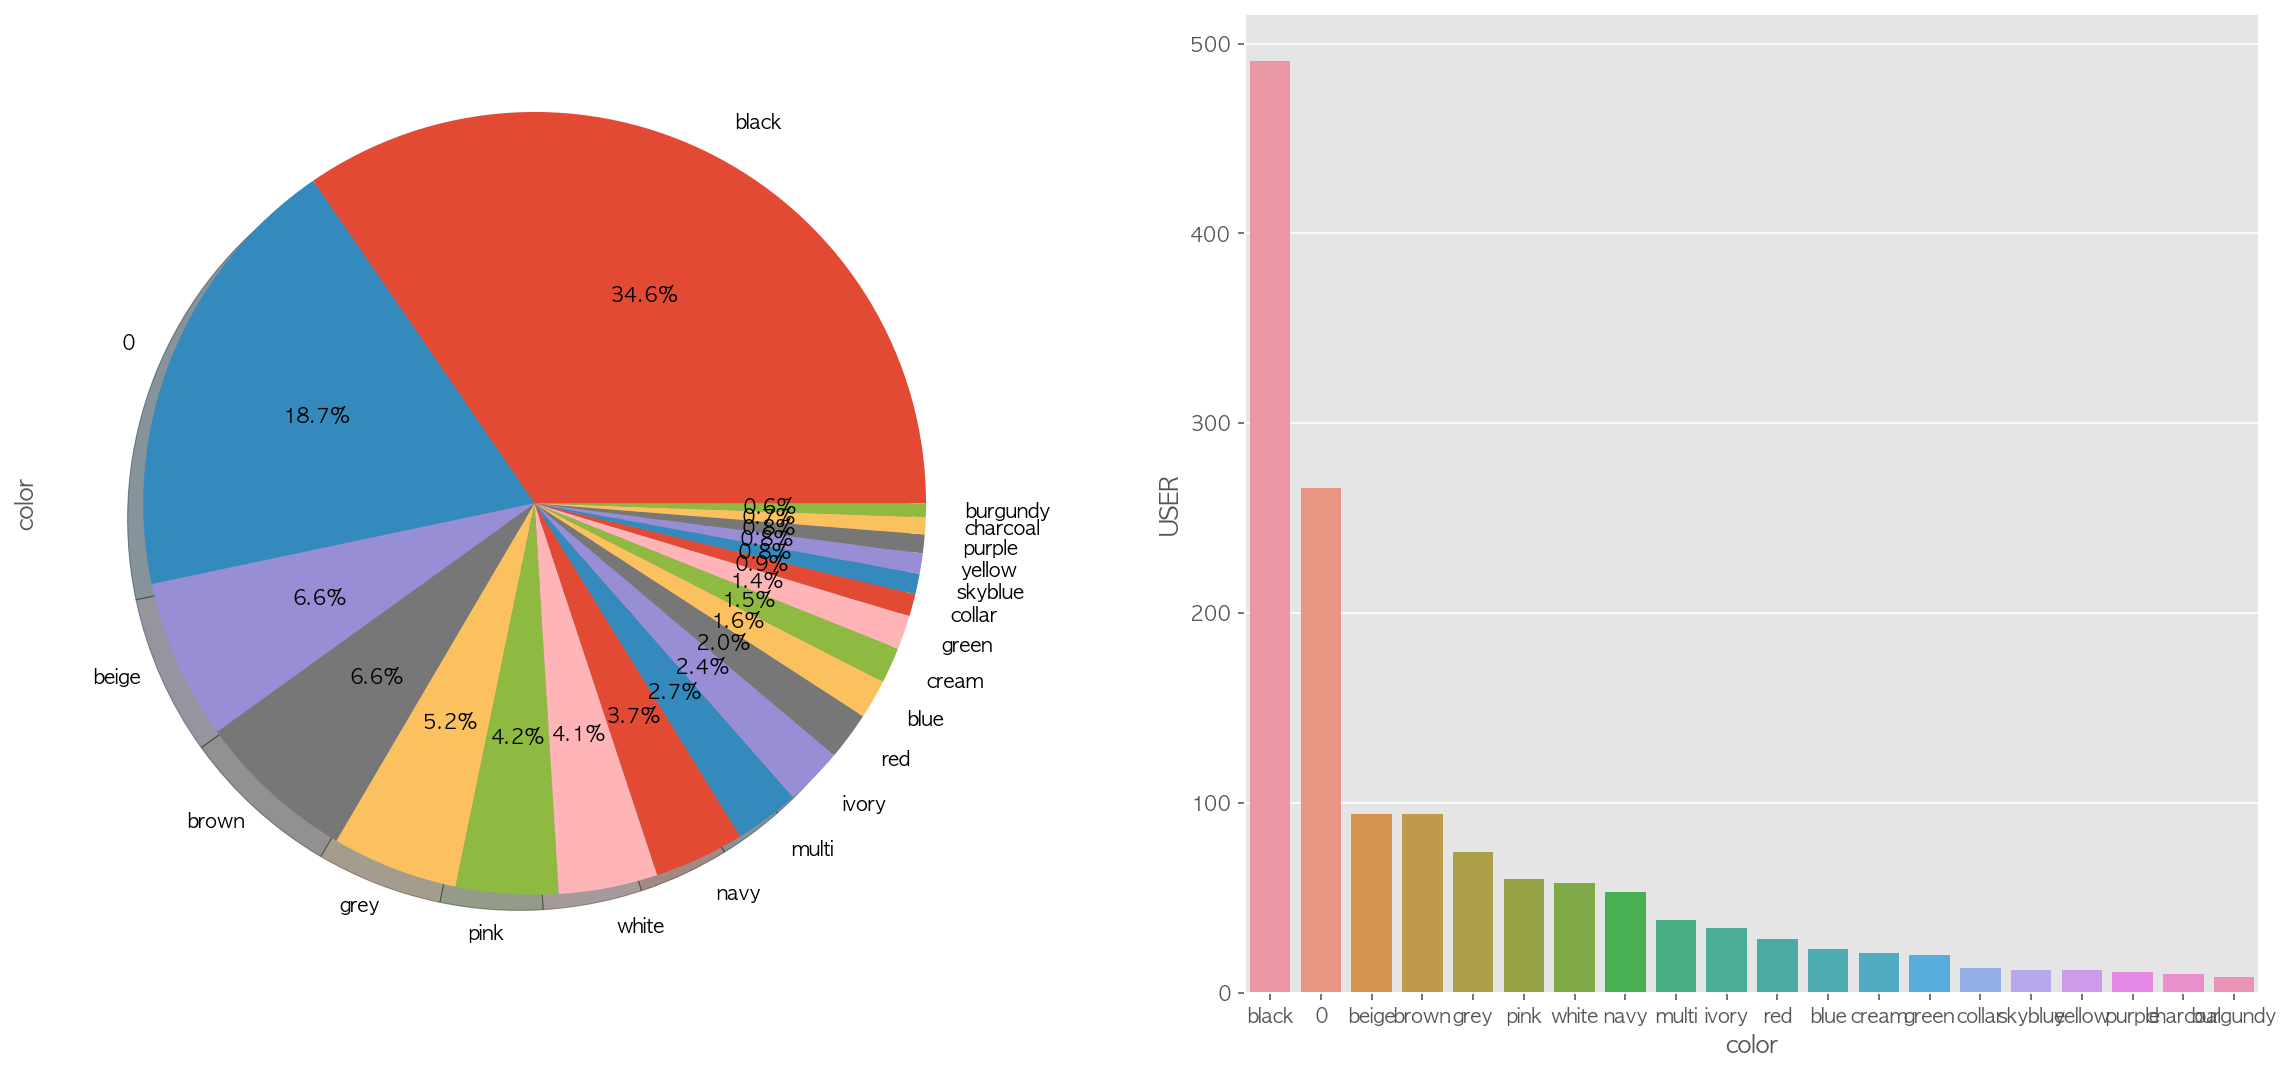

In [21]:
f, ax = plt.subplots(1,2, figsize = (20,9))

data['color'].value_counts()[:20].plot.pie(autopct = '%1.1f%%',shadow = True, ax=ax[0])
sns.barplot(data=color, x='color', y='USER', ax=ax[1])

### 어떤 제품을 구매하는지 확인

In [22]:
data['item'] = 0

def item_exit(item):
    for i in range(len(data)):
        if (item in data['component'][i]): 
            data['item'].iloc[i]=item

In [23]:
item_list = ['shoulder','jacket','skirt','top','zipup-jumper','coat',
             'fur-outer','cross','cardigan','padding','small',
             'hobo','dress','sweater','bucket',
            'sweat-shirts', 'jumper','turtle','body','lady',
             'clutch','mini',' shirt-dress','t-shirts','sleeveless','slacks',
             'blazer','medium', 'blouse', 'tote', 'belt', 'monogramtote',
            'hoodie', 'doublebreasted-jacket', 'duffle-coat', 'padding-outer',
            'crossbody', 'jump-suit', 'shirt', 'satchel', 'trench-coat', 'logo',
            'doublebreasted-coat', 'vest', 'shirts', 'way', 'chain',
            'singlebreated-jacket', 'box', 'dionysus', 'monogram', 'saffiano',
            'regular', 'moon', 'handle', '2jours', 'chino-pants', 'city',
            'tee', 'crossbody', 'satchel']

for i in item_list:
    item_exit(i)

In [24]:
# 중복 처리
for i in range(len(data)):
    if ('shoulder' in data['component'][i]):
       data['item'].iloc[i] = 'shoulder_bag'
    if ('clutch' in data['component'][i]):
       data['item'].iloc[i] = 'clutch_bag'
    if ('mini' in data['component'][i]):
       data['item'].iloc[i] = 'mini_bag'
    if ('logo' in data['component'][i]):
       data['item'].iloc[i] = 'logo_bag'
    if ('tote' in data['component'][i]):
       data['item'].iloc[i] = 'tote_bag'
    if ('cross' in data['component'][i]):
       data['item'].iloc[i] = 'cross_bag'
    if ('chain' in data['component'][i]):
       data['item'].iloc[i] = 'chain_bag'
    if ('body' in data['component'][i]):
       data['item'].iloc[i] = 'body_bag'

In [25]:
item = data.groupby('item').count()['USER'].sort_values(ascending=False)[:20].reset_index()

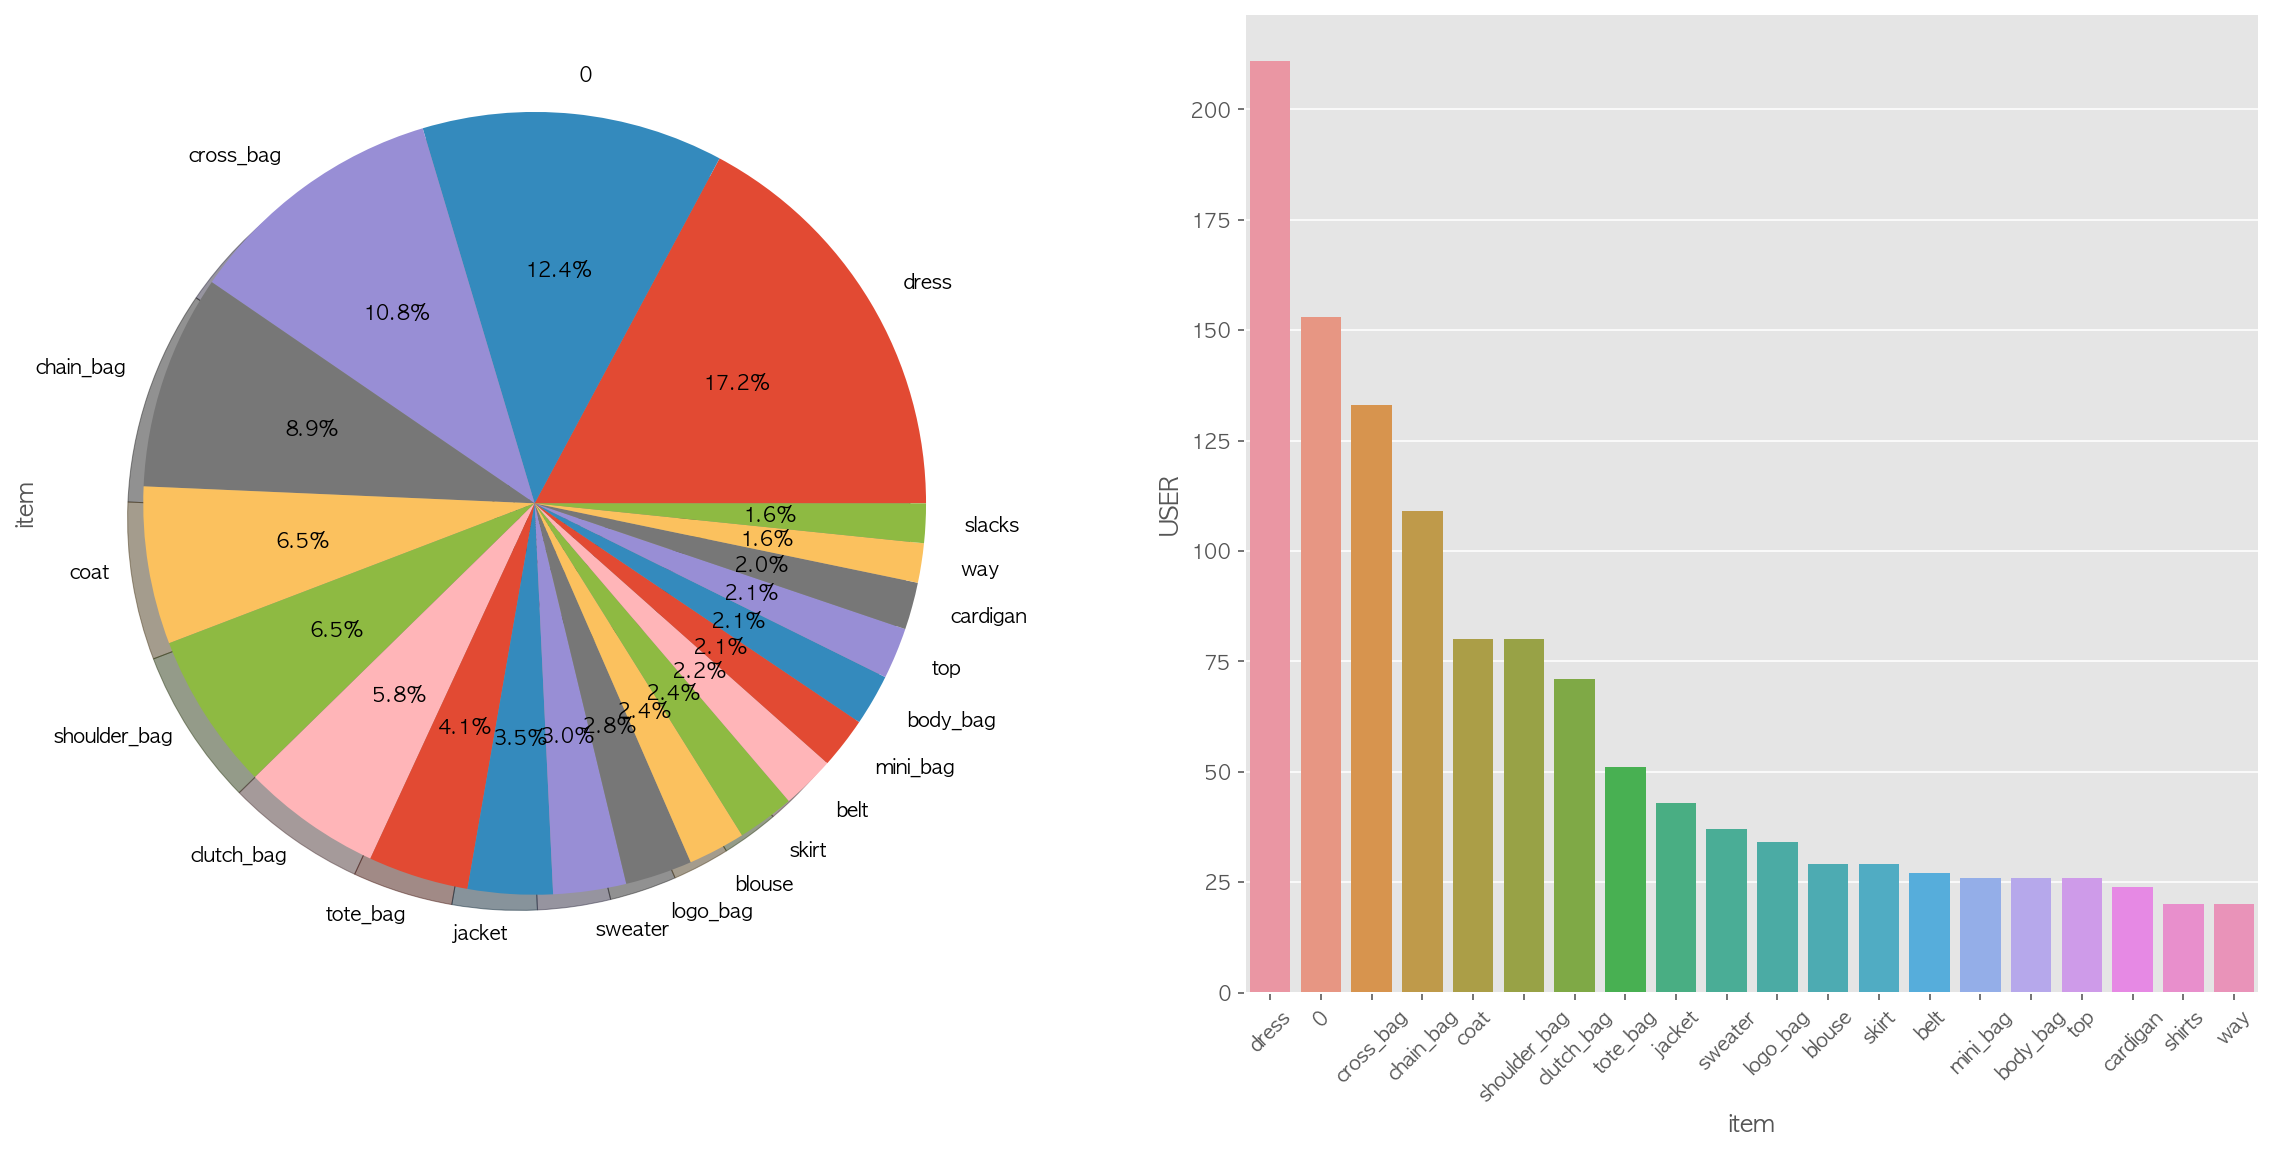

In [26]:
f, ax = plt.subplots(1,2, figsize = (20,9))

data['item'].value_counts()[:20].plot.pie(autopct = '%1.1f%%',shadow = True, ax=ax[0])
sns.barplot(data=item, x='item', y='USER', ax=ax[1])
plt.xticks(rotation = 45)
plt.show()

### 첫 구매에 어떤 아이템을 구매할지 확인

In [27]:
temp = pd.DataFrame(data.groupby(['USER','sub_type']).count()['goodsnm'].unstack())
temp.head()

sub_type,B,BA,D,O,T,TP
USER,,,,,,
a1100548,1,1,NaN,NaN,NaN,NaN
a1100887,NaN,1,NaN,NaN,NaN,NaN
a1101514,NaN,NaN,NaN,1,NaN,NaN
a1101645,NaN,1,NaN,NaN,NaN,NaN
a1102068,NaN,1,NaN,NaN,NaN,NaN


In [28]:
# user의 첫구매의 sub_type 
print("유저가 첫구매에 B를 포함할 확률:",temp['B'].notnull().sum()/len(temp))
print("유저가 첫구매에 BA를 포함할 확률:",temp['BA'].notnull().sum()/len(temp))
print("유저가 첫구매에 D를 포함할 확률:",temp['D'].notnull().sum()/len(temp))
print("유저가 첫구매에 O를 포함할 확률:",temp['O'].notnull().sum()/len(temp))
print("유저가 첫구매에 T를 포함할 확률:",temp['T'].notnull().sum()/len(temp))
print("유저가 첫구매에 TP를 포함할 확률:",temp['TP'].notnull().sum()/len(temp))

유저가 첫구매에 B를 포함할 확률: 0.03565640194489465
유저가 첫구매에 BA를 포함할 확률: 0.559967585089141
유저가 첫구매에 D를 포함할 확률: 0.17828200972447325
유저가 첫구매에 O를 포함할 확률: 0.20826580226904376
유저가 첫구매에 T를 포함할 확률: 0.1085899513776337
유저가 첫구매에 TP를 포함할 확률: 0.02188006482982172


### 이런 유저들의 retention rate 및 지속적인 신규 회원 유치를 위한 action plan은 추천 시스템이라고 생각

### 가장 인기있는 피쳐들 종합 
* 색상: 검은색
* 종류: 가방
* 브랜드: 구찌

## 추천 시스템 

### countvector를 사용한 version

In [29]:
count_vector = CountVectorizer()

In [30]:
goods_vector = count_vector.fit_transform(data['goodsnm'])
goods_vector

<1471x504 sparse matrix of type '<class 'numpy.int64'>'
	with 7276 stored elements in Compressed Sparse Row format>

In [31]:
# 코사인 유사도를 구한 벡터를 미리 저장
from sklearn.metrics.pairwise import cosine_similarity
goods_sim = cosine_similarity(goods_vector, goods_vector).argsort()[:,::-1]
print(goods_sim[:1])

[[   0  949  425 ... 1307  691  735]]


In [32]:
goods_sim.shape

(1471, 1471)

In [33]:
def find_sim(data, goods_name):
    # 특정 상품 정보 추출
    target_goodsnm_index = data[data['goodsnm']==goods_name].index.values
    
    # 코사인 유샤도 중 비슷한 코사인 유사도를 가진 정보 추출
    sim_index = goods_sim[target_goodsnm_index, :10].reshape(-1)
    # 본인 제외
    sim_index = sim_index[sim_index != target_goodsnm_index]
    
    # data frame 형성, vote_count로 정렬
    result = data.iloc[sim_index][:10]
    return result

In [34]:
find_sim(df, goods_name='buckle basic pattern zipup-jumper navy')

,brandnm,goodsnm,USER,reg_date,order_date,p_type,sub_type,app_yn,reg_date_ym,reg_date_w,reg_date_ymw,order_date_ym,order_date_w,order_date_ymw
135,Chanel,pocket graphics pattern zipup-jumper navy,a1112031,2020-08-15,2021-01-01,7days,O,N,20-08,3,20-08-3,21-01,1,21-01-1
291,ACNE STUDIOS,basic pattern sweater navy,a1143946,2021-01-21,2021-01-21,7days,T,Y,21-01,4,21-01-4,21-01,4,21-01-4
1304,Burberry London,basic pattern t-shirts navy,a187447,2020-03-09,2021-03-10,4days,T,N,20-03,3,20-03-3,21-03,2,21-03-2
1305,System,pocket basic pattern slacks navy,a187447,2020-03-09,2021-03-10,4days,B,N,20-03,3,20-03-3,21-03,2,21-03-2
453,Jil Sander,strap basic pattern coat navy,a1122824,2020-10-06,2021-02-24,7days,O,Y,20-10,2,20-10-2,21-02,4,21-02-4
1298,Valentino,pocket basic pattern slacks navy,a187924,2020-03-11,2021-03-10,7days,B,N,20-03,3,20-03-3,21-03,2,21-03-2
1214,Lucky Chouette,band basic pattern slacks navy,a1149519,2021-03-15,2021-03-16,7days,B,N,21-03,3,21-03-3,21-03,3,21-03-3
1173,BCBG Max Azria,basic pattern H-Line dress navy,a1149542,2021-03-16,2021-03-17,4days,D,Y,21-03,3,21-03-3,21-03,3,21-03-3
1018,Sandro,buckle basic pattern slacks black,a1150300,2021-03-22,2021-03-24,4days,B,Y,21-03,4,21-03-4,21-03,4,21-03-4


### TF-IDF를 활용한 version

In [35]:
# 많이 나오는 피쳐들 시각화를 위해 20으로 설정
tfidf = TfidfVectorizer(max_features = 20, max_df=0.95, min_df=0)

In [36]:
tfidf_matrix = tfidf.fit_transform(data['goodsnm'])
print(tfidf_matrix.shape)

(1471, 20)


In [37]:
# 제일 많이 나오는 20개의 피쳐 확인
tfidf_dict = tfidf.get_feature_names()
print(tfidf_dict)

['bag', 'basic', 'beige', 'black', 'brown', 'button', 'chain', 'check', 'clutch', 'coat', 'cross', 'detail', 'dress', 'jacket', 'line', 'monogram', 'pattern', 'pocket', 'quilted', 'shoulder']


In [38]:
data_array = tfidf_matrix.toarray()
df_data = pd.DataFrame(data_array, columns=tfidf_dict)
data.shape

(1471, 14)

In [39]:
# 2차원 배열로 바꾸어줌
tsne = TSNE(n_components=2, n_iter=10000, verbose=1)

In [40]:
data_array.T.shape

(20, 1471)

In [41]:
# 시각화를 위한 변환
Z = tsne.fit_transform(data_array.T)

[t-SNE] Computing 19 nearest neighbors...
[t-SNE] Indexed 20 samples in 0.000s...
[t-SNE] Computed neighbors for 20 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 20 / 20
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.255993
[t-SNE] KL divergence after 1450 iterations: 0.405578


In [42]:
print(Z[0:5])
print('Top words: ',len(Z))

[[ 78.555084  -50.07434  ]
 [126.155815  -16.23699  ]
 [ 32.50989    39.679127 ]
 [-55.722317   -3.3757405]
 [-50.323277   76.89137  ]]
Top words:  20


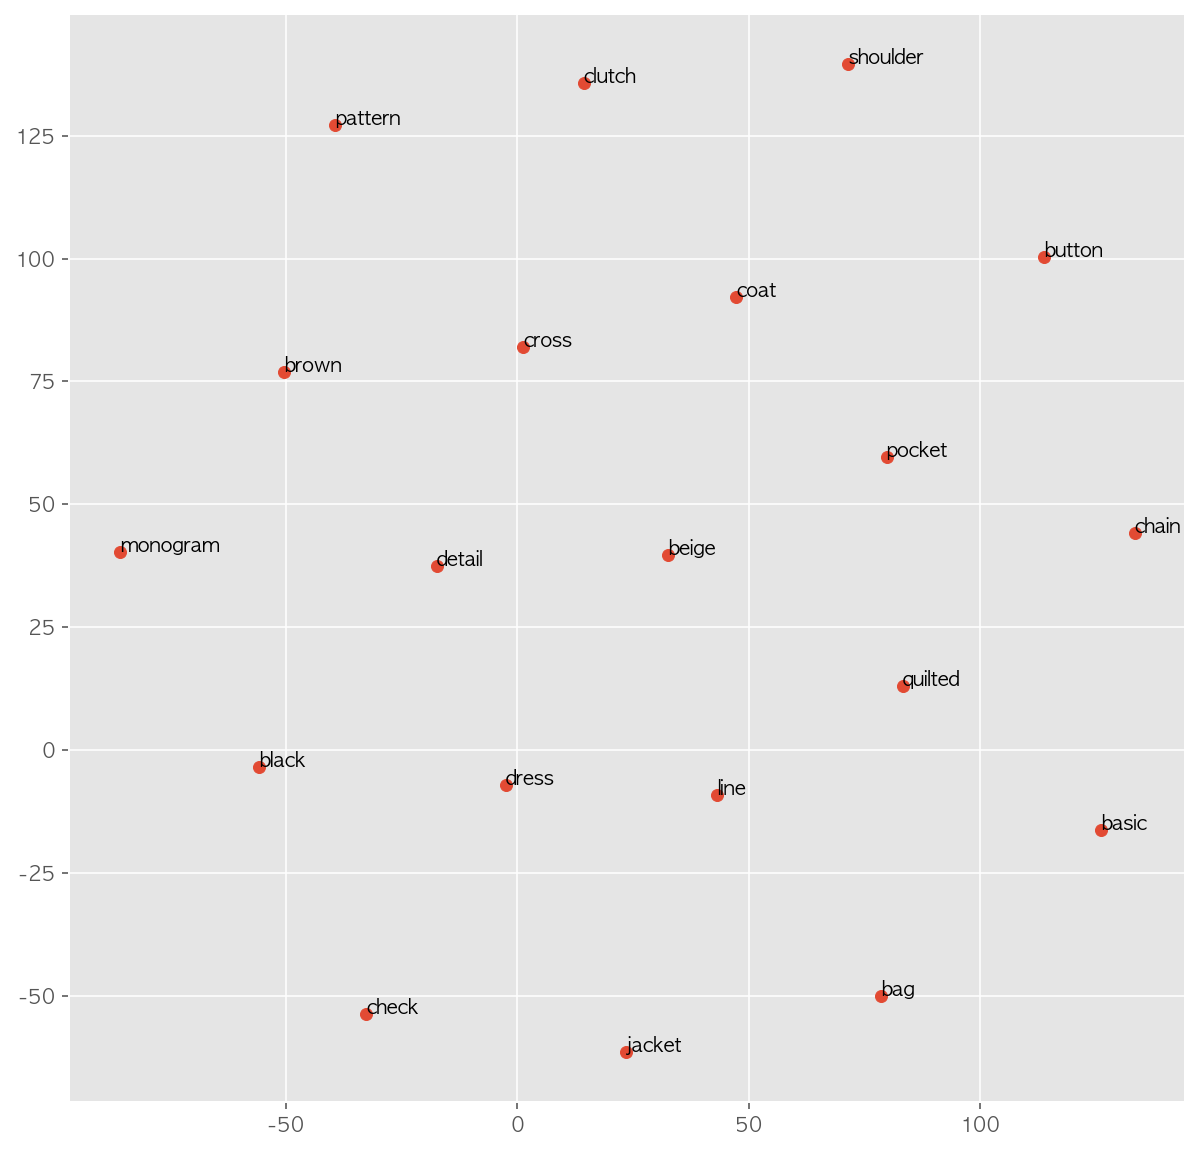

In [43]:
plt.figure(figsize=(10, 10))
plt.scatter(Z[:,0], Z[:,1])
for i in range(len(tfidf_dict)):
    plt.annotate(s=tfidf_dict[i].encode("utf8").decode("utf8"), xy=(Z[i,0], Z[i,1]))

plt.draw()

In [44]:
cosine_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_matrix.shape

(1471, 1471)

In [45]:
title2idx = {}
for i, c in enumerate(data['goodsnm']): 
    title2idx[i] = c

In [46]:
idx2title = {}
for i, c in title2idx.items(): 
    idx2title[c] = i

In [47]:
# 값을 기반으로 한 추천 
idx = idx2title['pocket graphics pattern sweat-pants white']
sim_scores = [(i, c) for i, c in enumerate(cosine_matrix[idx]) if i != idx] 
sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse=True) 
sim_scores[0:10]
sim_scores = [(title2idx[i], score) for i, score in sim_scores[0:10]]
sim_scores

[('pocket graphics pattern zipup-jumper navy', 1.0000000000000002),
 ('pocket graphics pattern hoodie yellow', 1.0000000000000002),
 ('pocket color block pattern fur-outer', 1.0000000000000002),
 ('pocket stripe pattern shirts pink', 1.0000000000000002),
 ('pocket Quilting pattern padding-outer khaki', 1.0000000000000002),
 ('pocket lettering pattern hoodie black', 0.9003970789078948),
 ('pocket stripe pattern slacks black', 0.9003970789078948),
 ('pocket basic pattern fur-outer ivory', 0.8591735945219221),
 ('pocket basic pattern fur-outer pink', 0.8591735945219221),
 ('pocket basic pattern fur-outer grey', 0.8591735945219221)]